## Read Data

In [1]:
from importlib import reload
import numpy as np

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob

def findFiles(path): return glob.glob(path)

data_dir = '/home/taot/data/AI/pytorch-tutorial/data/'

# print(findFiles(data_dir + 'names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles(data_dir + 'names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

Slusarski


In [3]:
import torch
import torch.nn as nn

In [4]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [5]:
letter_tensor = letterToTensor('A')
letter_tensor.shape

torch.Size([1, 57])

## Create Network

In [6]:
from torch.autograd import Variable

In [25]:
rnn = nn.LSTM(input_size=n_letters, hidden_size=n_categories, num_layers=1)

In [8]:
hidden = Variable(torch.zeros(1, rnn.hidden_size))

In [9]:
hidden = hidden.view(1, 1, n_categories)

In [10]:
input = Variable(letterToTensor('A'))

In [11]:
input = input.view(1, 1, n_letters)

In [12]:
cell = Variable(torch.zeros((1, 1, n_categories)))

In [13]:
output, (hidden, cell) = rnn.forward(input, (hidden, cell))

RuntimeError: Expected hidden[0] size (2, 1, 18), got (1, 1, 18)

## Prepare for Training

In [16]:
def categoryFromOutput(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

# print(categoryFromOutput(output))

In [105]:
torch.zeros(4)


 0
 0
 0
 0
[torch.FloatTensor of size 4]

In [17]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
#     category_tensor = Variable(torch.zeros(n_categories))
#     category_tensor[all_categories.index(category)] = 1
    line_tensor = Variable(lineToTensor(line))
    return category, line, category_tensor, line_tensor

for i in range(5):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Portuguese / line = Maria
category = Irish / line = Cleirigh
category = Irish / line = Niall
category = German / line = Slusser
category = Greek / line = Vassilikos


In [ ]:
line_tensor[0]

## Training

In [18]:
criterion = nn.NLLLoss()

In [30]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

In [26]:
lsoftmax = nn.LogSoftmax()

def train(category_tensor, line_tensor):
    hidden = Variable(torch.zeros(1, rnn.hidden_size))
    hidden = hidden.view(1, 1, n_categories)
    cell = Variable(torch.zeros((1, 1, n_categories)))

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        input = line_tensor[i].view(1, 1, n_letters)
        output, (hidden, cell) = rnn(input, (hidden, cell))

#     print('output.shape: ' + str(output.shape))
#     print('category_tensor.shape: ' + str(category_tensor.shape))
#     print(category_tensor[0])
    output = output.view(1, n_categories)
    output = lsoftmax(output)
    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.data[0]

In [31]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

/home/taot/opt/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


5000 5% (0m 13s) 1.7224 Connell / Irish ✓
10000 10% (0m 29s) 2.6064 Kuhn / Chinese ✗ (German)
15000 15% (0m 43s) 2.9441 Wood / Polish ✗ (Scottish)
20000 20% (0m 58s) 2.5877 Hyobanshi / Italian ✗ (Japanese)
25000 25% (1m 13s) 1.9374 Basurto / Portuguese ✓
30000 30% (1m 27s) 2.8013 Young / Chinese ✗ (English)
35000 35% (1m 41s) 1.9867 Borchard / Irish ✗ (German)
40000 40% (1m 55s) 1.8378 Pape / Spanish ✗ (French)
45000 45% (2m 9s) 1.6512 Xin / Korean ✗ (Chinese)
50000 50% (2m 23s) 1.5191 Sevriens / Dutch ✓
55000 55% (2m 37s) 1.6906 Dang / Chinese ✗ (Vietnamese)
60000 60% (2m 52s) 1.8979 Pho / Korean ✗ (Vietnamese)
65000 65% (3m 6s) 1.7299 Baldi / Italian ✓
70000 70% (3m 20s) 1.5506 Kaminski / Polish ✓
75000 75% (3m 35s) 1.6579 Morrison / Scottish ✓
80000 80% (3m 50s) 1.5729 Koziol / Polish ✓
85000 85% (4m 4s) 2.9155 Kaiser / Dutch ✗ (Czech)
90000 90% (4m 19s) 2.9400 Rashid / Scottish ✗ (English)
95000 95% (4m 33s) 1.8300 Prieto / Italian ✗ (Spanish)
100000 100% (4m 48s) 1.8122 Mcdonald /

## Evaluating Results

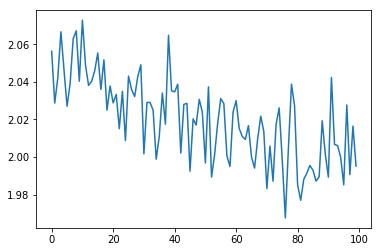

In [33]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

In [28]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

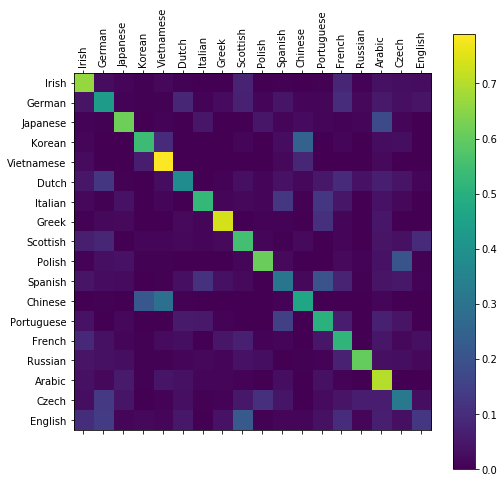

In [32]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = Variable(torch.zeros(1, rnn.hidden_size))
    hidden = hidden.view(1, 1, n_categories)
    cell = Variable(torch.zeros((1, 1, n_categories)))

    for i in range(line_tensor.size()[0]):
        input = line_tensor[i].view(1, 1, n_letters)
        output, (hidden, cell) = rnn(input, (hidden, cell))

    output = output.view(1, n_categories)
    
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

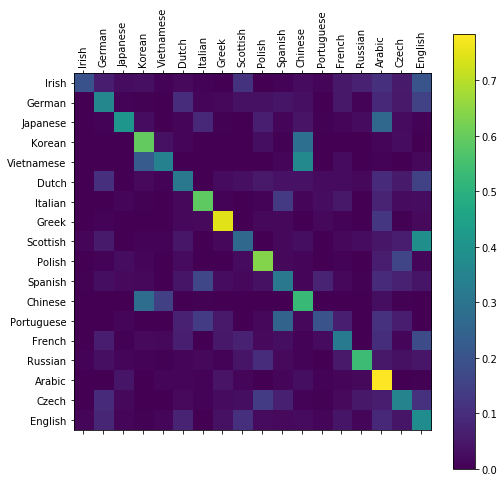